# Setup

In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import math

from utils.function_utils import polynomial, taylor_expand_2d, polynomial_multiply, polynomial_sum, polynomial_power, print_polynomial, latex_polynomial
from utils.function_utils import integrate_taylor_polynomial, derivative_t_polynomial, taylor_expand_2d, matching_coeffs, build_powers, reduce_order

from utils.distribution_utils import q

from utils.qcd_utils import running_coupling   


# Plot
import matplotlib.pyplot as plt
from rikabplotlib.plot_utils import newplot, hist_with_errors


In [2]:
# JAX vmapping and compilation
jitted_q  = jax.jit(q)
vmapped_q = jax.vmap(q, in_axes=(0, None, None, None))

jitted_polynomial = jax.jit(polynomial)
vmapped_polynomial = jax.vmap(polynomial, in_axes=(0, None))

# Problem Definition

In [3]:
OPAL_DATA = np.array([
    [0.004849660523763337, 1.2754409769335133],
    [0.014742967992240535, 12.917232021709632],
    [0.02521823472356935, 18.534599728629576],
    [0.03491755577109602, 13.568521031207597],
    [0.04461687681862268, 9.660786974219809],
    [0.05470417070805042, 7.327001356852101],
    [0.0649854510184287, 5.671641791044777],
    [0.0748787584869059, 4.586160108548167],
    [0.08457807953443258, 3.7177747625508815],
    [0.0946653734238603, 3.066485753052916],
    [0.10494665373423859, 2.6594301221166887],
    [0.11483996120271578, 2.2523744911804577],
    [0.124733268671193, 1.9538670284938924],
    [0.13501454898157125, 1.6282225237449133],
    [0.14490785645004847, 1.4111261872455891],
    [0.15499515033947622, 1.2754409769335133],
    [0.16488845780795341, 1.1397557666214375],
    [0.17478176527643063, 0.9769335142469444],
    [0.1850630455868089, 0.8683853459972894],
    [0.1949563530552861, 0.7869742198100411],
    [0.20387972841901064, 0.678426051560379],])

OPAL_DATA_UPEPR = np.array([
    [0.0052376333656644, 1.5196743554952512],
    [0.015130940834141612, 13.405698778833106],
    [0.025024248302618804, 19.240162822252373],
    [0.035111542192046555, 13.839891451831749],
    [0.04519883608147429, 9.8236092265943],
    [0.0550921435499515, 7.435549525101765],
    [0.06517943743937923, 5.780189959294436],
    [0.07507274490785644, 4.694708276797829],
    [0.08516003879728418, 3.7991858887381262],
    [0.0950533462657614, 3.1478968792401645],
    [0.10514064015518912, 2.7408412483039335],
    [0.11522793404461687, 2.279511533242875],
    [0.12512124151309406, 2.008141112618727],
    [0.1352085354025218, 1.709633649932158],
    [0.14490785645004847, 1.492537313432834],
    [0.15518913676042673, 1.329715061058348],
    [0.16508244422890395, 1.194029850746265],
    [0.17497575169738114, 1.0583446404341927],
    [0.1850630455868089, 0.9226594301221169],
    [0.1949563530552861, 0.8412483039348722],
    [0.20387972841901064, 0.7055630936227963],])


OPAL_ERRORS = jnp.abs(OPAL_DATA_UPEPR[:,1] - OPAL_DATA[:,1])


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


0.47236225 0.47290823 0.47290823
-0.075121135 -0.08712275 -0.09164957


Text(0, 0.5, '$\\frac{1}{\\sigma} \\frac{d\\sigma}{dt}$')

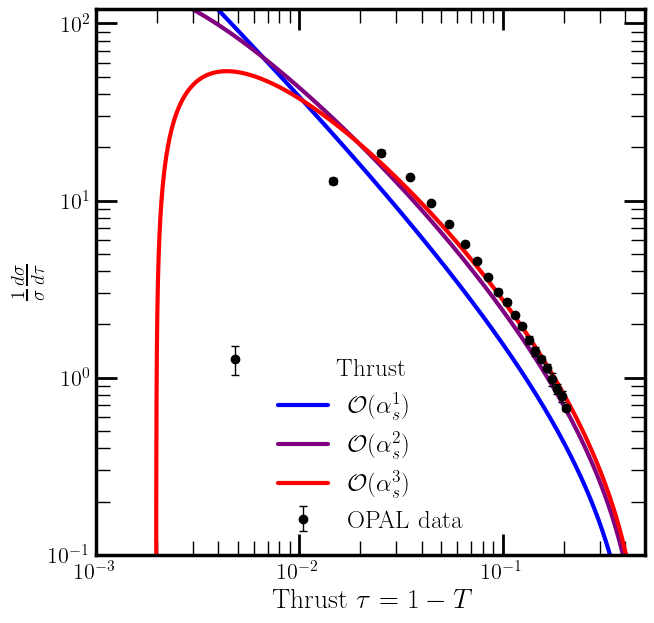

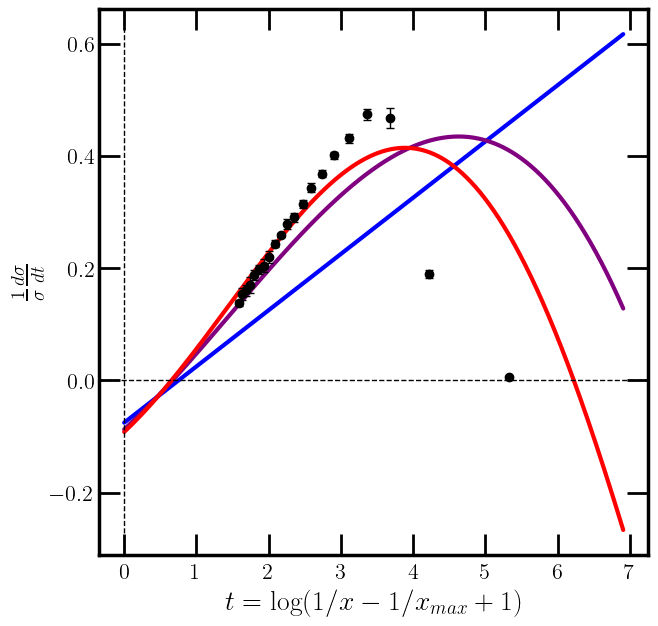

In [6]:

# Define the t function as it relates to x. 
# x_max = 0.47236225

def build_transforms(x_max):

    # def t_from_x(x):
    #     return jnp.log(1/x - 1/x_max + 1)

    # def jacobian_t_from_x(x):

    #     return 1 / (1/x - 1/x_max + 1) * 1/x**2

    # def x_from_t(t):
    #     return 1/(-1 + jnp.exp(t) + 1/x_max) 
    
    # def jacobian_x_from_t(t):
    #     return 1 / (-1 + jnp.exp(t) + 1/x_max)**2 * jnp.exp(t)
    

    def t_from_x(x):
        return jnp.log(x_max / x)

    def jacobian_t_from_x(x):

        return jnp.abs(1 / x)

    def x_from_t(t):
        return x_max * jnp.exp(-t) 
    
    def jacobian_x_from_t(t):
        return jnp.abs(x_max * jnp.exp(-t))

    return t_from_x, x_from_t, jacobian_t_from_x, jacobian_x_from_t

# xmaxs = [0.47236225, 0.47236225, 0.47236225,]
# xmaxs = [0.5, 0.5, 0.5,]
xmaxs = [1.0, 1.0, 1.0,]

t_from_xs = []
x_from_ts = []
jacobian_t_from_xs = []
jacobian_x_from_ts = []
for xmax in xmaxs:
    t_from_x, x_from_t, jacobian_t_from_x, jacobian_x_from_t = build_transforms(xmax)
    t_from_xs.append(t_from_x)
    x_from_ts.append(x_from_t)
    jacobian_t_from_xs.append(jacobian_t_from_x)
    jacobian_x_from_ts.append(jacobian_x_from_t)


# Define the FO distribution p(t | alpha) as either a function of t or x

C_F = 4/3
C_A = 3
T_F = 1/2
n_f = 5
zeta_3 = 1.20205690315959
zeta_5 = 1.03692775514337
c_2CF_S = 58.00 # +-2
c_2CA_S = -60 # +- 1
c_2nf_S = 43.00 # +- 1
mz = 91.1876


order = 1

def p_x_1(x, alpha, params):
    return p_x_order(x, alpha, 1)

def p_x_2(x, alpha, params):
    return p_x_order(x, alpha, 2)

def p_x_3(x, alpha, params):
    return p_x_order(x, alpha, 3)

def p_x_order(x, alpha, order ):

    scale = 91.1876 * x
    alpha_s = running_coupling(alpha, mz, mz)


    funcs = [DA, DB, DC]
    alpha_bar = alpha_s / (2 * np.pi)
    
    res = jnp.zeros_like(x)

    for o in range(order):
        res += alpha_bar**(o + 1) * funcs[o](x)
    return res


def DA(x):
    return 1/x * (C_F) * (-4 * jnp.log(x)  - 3)

def DB(x):

    L = jnp.log(x)
    term1 = C_F**2 * (8*L**3 + 18*L**2 + (13 - 4*np.pi**2)*L  + 9/4 - 2*np.pi**2 + 4*zeta_3)
    term2 = C_F * T_F * n_f * (-4 * L**2 + 22/9 *L + 5)
    term3 = C_F * C_A * (11 * L**2 + (-169 / 18 + 2*np.pi**2 /3) * L - 57/4 + 6*zeta_3)

    return 1/x * (term1 + term2 + term3)


def DC(x):
    pi2 = jnp.pi**2
    pi4 = jnp.pi**4
    L = jnp.log(x)
    prefactors = jnp.array([1*C_F**3, 1*C_F**2 * n_f * T_F,  1*C_F * n_f**2 * T_F**2, 1*C_F * C_A**2, 1*C_F**2 * C_A, C_A * C_F * n_f * T_F])

    # From L^5 to L^0
    terms = jnp.array([[-8, -30, (-44 + 40*np.pi**2 / 3), (-88*zeta_3 + 24*np.pi**2 - 27), (-c_2CF_S -96*zeta_3 + 53*pi2**2/90 + 79*pi2/6 - 17/2), (16*pi2*zeta_3 - 39*zeta_3 - 132*zeta_5 + 19*pi2**2/120 + 5/8*pi2 - 47/8 - 3/4 *c_2CF_S)], # C_F^3
             [0, 40/3, 56/9, (-43 - 28*pi2/3), (-c_2nf_S + 664*zeta_3/9 + 164*pi2/27 - 1495/81), (274 * zeta_3 / 9 - 31 * pi4 / 45 + 56*pi2/9 + 1511/108 + 2/3 * c_2CF_S - 3/4 * c_2nf_S) ],
             [0.0, 0.0, -112/27, 68/9, (140/81 + 16 * pi2 / 27), (-176 * zeta_3 / 27 - 64*pi2/81 - 3598/243 + 2*c_2nf_S/3)],
             [0.0, 0.0, -847/27, (3197/36 - 11*pi2/3), (22 * zeta_3 - 11*pi4/45 + 85*pi2/9 - 11323/324), (-10*zeta_5 + 361*zeta_3/27 + 541*pi4/540 - 739*pi2/81 - 77099/486 - 11/6 * c_2CA_S)],
             [0.0, -110/3, (-58/9 - 8*pi2/3), (-36*zeta_3 + 68*pi2/3 + 467/4), (-2870*zeta_3/9 + 173*pi4/90 - 625*pi2/27 + 29663/324 - c_2CA_S), (-30 * zeta_5 - 1861*zeta_3/18 + 973*pi4/360 - 317*pi2/18 - 49/27 - 11/6 * c_2CF_S - 3/4 * c_2CA_S)],
             [0.0, 0.0, 616/27, 4*pi2/3 - 512/9, (8*zeta_3 - 128*pi2/27 + 673/81), (608*zeta_3/27 - 10*pi4/27 + 430*pi2/81 + 24844/243 - 11/6*c_2nf_S + 2/3 * c_2CA_S)]
    ])



    Ls = jnp.array([L**5, L**4, L**3, L**2, L**1, 1*L**0])
    res = prefactors[:, None] * terms
    res = res * Ls[None, :]
    res = res.sum()
    return 1/x * res
    # return 1/x * 

vmapped_p_x_1 = jax.vmap(p_x_1, in_axes=(0, None, None))
vmapped_p_x_2 = jax.vmap(p_x_2, in_axes=(0, None, None))
vmapped_p_x_3 = jax.vmap(p_x_3, in_axes=(0, None, None))

alpha = 0.118/100
test_xs = jnp.linspace(0.25, 0.55, 100000)
max_nonzero_x_1 = test_xs[jnp.argmin(jnp.abs(vmapped_p_x_1(test_xs, alpha, None)))-1]
max_nonzero_x_2 = test_xs[jnp.argmin(jnp.abs(vmapped_p_x_2(test_xs, alpha, None)))-1]
max_nonzero_x_3 = test_xs[jnp.argmin(jnp.abs(vmapped_p_x_3(test_xs, alpha, None)))-1]


print(max_nonzero_x_1, max_nonzero_x_2, max_nonzero_x_3)


def p_t_1(t, alpha, params):

    x_from_t = x_from_ts[0]
    jacobian_x_from_t = jacobian_x_from_ts[0]
    return p_x_1(x_from_t(t), alpha, params) * jacobian_x_from_t(t)

def p_t_2(t, alpha, params):

    x_from_t = x_from_ts[1]
    jacobian_x_from_t = jacobian_x_from_ts[1]
    return p_x_2(x_from_t(t), alpha, params) * jacobian_x_from_t(t)


def p_t_3(t, alpha, params):

    x_from_t = x_from_ts[2]
    jacobian_x_from_t = jacobian_x_from_ts[2]
    return p_x_3(x_from_t(t), alpha, params) * jacobian_x_from_t(t)

print(p_t_1(0, 0.118, None), p_t_2(0, 0.118, None), p_t_3(0, 0.118, None))

vmapped_p_t_1 = jax.vmap(p_t_1, in_axes=(0, None, None))
vmapped_p_t_2 = jax.vmap(p_t_2, in_axes=(0, None, None))
vmapped_p_t_3 = jax.vmap(p_t_3, in_axes=(0, None, None))

vmapped_ps = [vmapped_p_t_1, vmapped_p_t_2, vmapped_p_t_3]

# def p_ideal(t, alpha, params):
#     alpha_bar = alpha #* 4/3 / jnp.pi
#     return jnp.exp(-0.5 * alpha_bar * t**2 + 0.5 * alpha_bar**2 * t **4 - 0.5 * alpha_bar**3 * t**6) * (alpha_bar * t - 2 * alpha_bar**2 * t**3 + 3 * alpha_bar**3 * t**5)


# # Taylor expansion of p(t| alpha) = exp(-alpha * t**2)(alpha * t)
# def p_t(t, alpha, params):
#     alpha_bar = alpha #* 4/3 / jnp.pi
#     return alpha_bar * t #-  2.5 * alpha_bar**2 * t**3

# p_x_ideal = lambda x, alpha, params: p_ideal(t_from_x(x), alpha, params) * jnp.abs(1/x)
# p_x = lambda x, alpha, params: p_t(t_from_x(x), alpha, params) * jnp.abs(1/x)

# def p_x(x, alpha, params):
#     return p_t(t_from_x(x), alpha, params) * jnp.abs(1/x)


# Plot
xs = jnp.logspace(-3, 0, 10000) 
ts = t_from_x(xs)

fig, ax = newplot("full")
# ax.plot(xs, p_x_idea(xs, 0.118, None), label="Ideal", color = "grey")
ax.plot(xs, vmapped_p_x_1(xs, 0.118, None) , label=r"$\mathcal{O}(\alpha_s^1)$", color = "blue")
ax.plot(xs, vmapped_p_x_2(xs, 0.118, None) , label=r"$\mathcal{O}(\alpha_s^2)$", color = "purple")
ax.plot(xs, vmapped_p_x_3(xs, 0.118, None) , label=r"$\mathcal{O}(\alpha_s^3)$", color = "red")
ax.errorbar(OPAL_DATA[:,0], OPAL_DATA[:,1], yerr=OPAL_ERRORS, fmt='o', label="OPAL data", c  = "black", capsize=3, lw = 1)



ax.set_xscale("log")
ax.set_yscale("log")

plt.legend(title = "Thrust")

plt.xlim(0.001, 0.25  / 0.5)
plt.ylim(0.1, 120)
# plt

plt.xlabel(r"Thrust $\tau = 1 - T$")
plt.ylabel(r"$\frac{1}{\sigma} \frac{d\sigma}{d\tau}$")

plt.savefig("plots/thrust_opal.pdf")


fig, ax = newplot("full")
ax.plot(ts, vmapped_p_t_1(ts, 0.118, None), label=r"$\mathcal{O}(\alpha_s^1)$", color = "blue")
ax.plot(ts, vmapped_p_t_2(ts, 0.118, None), label=r"$\mathcal{O}(\alpha_s^2)$", color = "purple")
ax.plot(ts, vmapped_p_t_3(ts, 0.118, None), label=r"$\mathcal{O}(\alpha_s^3)$", color = "red")
ax.errorbar(t_from_x(OPAL_DATA[:,0]), OPAL_DATA[:,1] * OPAL_DATA[:,0], yerr=OPAL_ERRORS * OPAL_DATA[:,0], fmt='o', label="OPAL data", c  = "black", capsize=3, lw = 1)

ax.axhline(0, color = "black", linestyle = "--", lw = 1)
ax.axvline(0, color = "black", linestyle = "--", lw = 1)

plt.xlabel(r"$t = \log(1/x - 1/{x_{max}} + 1)$")
plt.ylabel(r"$\frac{1}{\sigma} \frac{d\sigma}{dt}$")
# plt.yscale("log")


In [7]:
coeffs = (taylor_expand_2d(p_t_2, 0.0, 0.0, 4, 4))
print_polynomial(coeffs)


print(latex_polynomial(coeffs))



c_0,0 = 0.00e+00 c_0,1 = -0.00e+00 c_0,2 = -0.00e+00 c_0,3 = -0.00e+00 c_0,4 = -0.00e+00 
c_1,0 = -6.37e-01 c_1,1 = 8.49e-01 c_1,2 = 0.00e+00 c_1,3 = 0.00e+00 c_1,4 = 6.32e-09 
c_2,0 = -8.62e-01 c_2,1 = 1.27e+00 c_2,2 = 1.59e+00 c_2,3 = -3.60e-01 c_2,4 = 0.00e+00 
c_3,0 = 0.00e+00 c_3,1 = 0.00e+00 c_3,2 = 0.00e+00 c_3,3 = 0.00e+00 c_3,4 = 0.00e+00 
c_4,0 = 0.00e+00 c_4,1 = 0.00e+00 c_4,2 = 0.00e+00 c_4,3 = 0.00e+00 c_4,4 = 0.00e+00 
\begin{pmatrix}
0.00e+00 & -0.00e+00 & -0.00e+00 & -0.00e+00 & -0.00e+00 \\ 
-6.37e-01 & 8.49e-01 & 0.00e+00 & 0.00e+00 & 6.32e-09 \\ 
-8.62e-01 & 1.27e+00 & 1.59e+00 & -3.60e-01 & 0.00e+00 \\ 
0.00e+00 & 0.00e+00 & 0.00e+00 & 0.00e+00 & 0.00e+00 \\ 
0.00e+00 & 0.00e+00 & 0.00e+00 & 0.00e+00 & 0.00e+00 \end{pmatrix}



In [ ]:
g_star = jnp.array([[-1]])
ts = jnp.linspace(0, 1, 1000)
print(vmapped_q(ts, 0.1, g_star, coeffs))





[       nan 0.9906159  0.98951894 0.9884232  0.9873289  0.98623586
 0.98514414 0.9840536  0.9829645  0.9818767  0.98079014 0.97970486
 0.97862095 0.9775383  0.97645694 0.97537684 0.974298   0.9732206
 0.97214437 0.9710695  0.9699958  0.9689235  0.9678524  0.9667826
 0.9657141  0.96464694 0.96358097 0.9625163  0.96145284 0.9603907
 0.9593298  0.95827013 0.9572118  0.9561547  0.955099   0.95404434
 0.95299107 0.95193905 0.9508882  0.9498387  0.9487904  0.9477433
 0.94669753 0.945653   0.9446097  0.94356763 0.9425268  0.94148725
 0.9404489  0.9394118  0.93837595 0.93734133 0.93630797 0.9352758
 0.9342448  0.93321514 0.93218666 0.9311594  0.9301334  0.92910856
 0.928085   0.92706263 0.9260415  0.9250215  0.9240028  0.9229853
 0.92196906 0.920954   0.9199402  0.91892743 0.917916   0.9169057
 0.91589665 0.9148888  0.9138821  0.9128768  0.91187257 0.9108695
 0.9098676  0.9088669  0.90786743 0.90686905 0.905872   0.9048761
 0.9038814  0.9028877  0.9018954  0.90090424 0.89991415 0.8989253
 0.89

In [10]:
ps = [p_t_1]
order = len(ps)


t = jnp.linspace(0, 20, 1000)


num_trials = 5
colors = []

factorials = np.zeros((4,4))
for i in range(factorials.shape[0]):
    for j in range(factorials.shape[1]):
        factorials[i, :] = math.factorial(i) * math.factorial(j)



data = np.zeros((order, t.shape[0], num_trials))
extra_orders = 1

for o in range(order):


    m_order = (o+1)
    n_order = 2 * (o+1)

    # Normalization array, size includes extra orders
    factorials = np.zeros((m_order + 1 + extra_orders, n_order + 1 + extra_orders))
    for i in range(factorials.shape[0]):
        for j in range(factorials.shape[1]):
            factorials[i, j] = (i+1) # math.factorial(i) #* math.factorial(j)


    # Actually perform the matching
    print("Order: ", o+1)
    g_mn_matched, g_star = matching_coeffs(ps[o], m_order, n_order)
    print("g_mn_matched")
    print(g_mn_matched)

    print("g_star")
    print(g_star)


    for trial in range(num_trials):

        # Get a random seed
        seed = jax.random.PRNGKey(trial * 1000 + o * 100) 

        # print(g_mn_matched)
        # print(g_star)
    
        # Prior on the g_mn
        std = 10 / factorials
        g_mn = (2 * (jax.random.uniform(seed, factorials.shape))-1) *  0.01 * std# - (std / 2)
        max_m = g_mn.shape[0]
        max_n = g_mn.shape[1]


        # set the highest order term to be negative
        g_mn = g_mn.at[m_order+1:max_m, max_n-1].set(-jnp.abs(g_mn[m_order+1:max_m, max_n-1]))

        # Set the coefficients of the random array to be the matched ones
        g_mn = g_mn.at[:m_order+1, :].set(0)
        g_mn = g_mn.at[:m_order+1, :n_order+1].set(g_mn_matched)

        print("g_mn")
        print(g_mn)

        # Save the curve
        data[o, :, trial] = jnp.nan_to_num(vmapped_q(t, 0.118, g_star, g_mn))

        def temp_q(t, alpha, params):
            return q(t, alpha, g_star, g_mn)
        
        # print the taylor expansion
        print("Taylor expansion")
        taylor_coeffs = taylor_expand_2d(temp_q, 0.0, 0.0, m_order, n_order)
        print_polynomial(taylor_coeffs)




Order:  1
g_mn_matched
[[ 0.         -1.3333334  -0.88888896]
 [ 0.         -0.63661975  0.42441317]]
g_star
[[0.         0.         0.        ]
 [0.63661975 0.         0.        ]]
g_mn
[[ 0.         -1.3333334  -0.88888896  0.        ]
 [ 0.         -0.63661975  0.42441317  0.        ]
 [-0.00565836 -0.02259144 -0.0167606  -0.00718759]]
Taylor expansion
c_0,0 = nan c_0,1 = nan c_0,2 = nan 
c_1,0 = nan c_1,1 = nan c_1,2 = nan 
g_mn
[[ 0.         -1.3333334  -0.88888896  0.        ]
 [ 0.         -0.63661975  0.42441317  0.        ]
 [ 0.02348022 -0.03054973  0.03309734 -0.01464312]]
Taylor expansion
c_0,0 = nan c_0,1 = nan c_0,2 = nan 
c_1,0 = nan c_1,1 = nan c_1,2 = nan 
g_mn
[[ 0.         -1.3333334  -0.88888896  0.        ]
 [ 0.         -0.63661975  0.42441317  0.        ]
 [ 0.00270171  0.01207197  0.02972061 -0.0261825 ]]
Taylor expansion
c_0,0 = nan c_0,1 = nan c_0,2 = nan 
c_1,0 = nan c_1,1 = nan c_1,2 = nan 
g_mn
[[ 0.         -1.3333334  -0.88888896  0.        ]
 [ 0.       

-inf
-inf
-inf
-inf
-inf


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1746: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)
/tmp/ipykernel_232506/982261362.py:34: RuntimeWarning: invalid value encountered in add
  ax.plot(xs, mean + std, color = colors[i], linestyle = "--", alpha = 0.5, lw = 1)
/tmp/ipykernel_232506/982261362.py:35: RuntimeWarning: invalid value encountered in add
  ax.fill_between(xs, mean - std, mean + std, color = "white", alpha = 0.99, ls = "--")
/tmp/ipykernel_232506/982261362.py:36: Runti

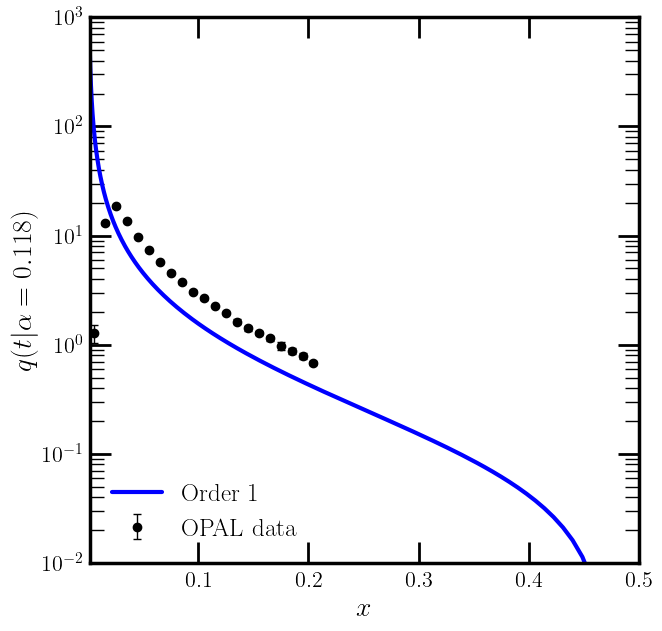

In [9]:
fig, ax = newplot("full", sharex=True)

order = len(ps)
colors = ["blue", "purple", "red"]
xs = x_from_t(t)


plot_x = True

for i in range(order):


    x_from_t = x_from_ts[i]
    jacobian_t_from_x = jacobian_t_from_xs[i]

    ax.plot(xs, vmapped_ps[i](t, 0.118, i) * jacobian_t_from_x(xs), label=f"Order {i+1}", color = colors[i],)



    for trial in range(num_trials):

        ax.plot(xs, data[i, :,trial] * jacobian_t_from_x(xs), color = colors[i], linestyle = "--", alpha = 0.05, lw = 0.5)
        # ax[1].plot(t, data[order, :,trial] / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--", alpha = 0.05, lw = 0.5)

        # print integral
        print(jnp.trapz(np.nan_to_num(data[i, :,trial]), t))


    mean = np.nanmean(data[i] * jacobian_t_from_x(xs[:,None]), axis = 1)
    std = np.nanstd(data[i] * jacobian_t_from_x(xs[:,None]), axis = 1)

    # plt.plot(t, mean, color = colors[order], linestyle = "--", label = f"Order {order} Mean")
    ax.plot(xs, mean - std, color = colors[i], linestyle = "--", alpha = 0.5, lw = 1)
    ax.plot(xs, mean + std, color = colors[i], linestyle = "--", alpha = 0.5, lw = 1)
    ax.fill_between(xs, mean - std, mean + std, color = "white", alpha = 0.99, ls = "--")
    ax.fill_between(xs, mean - std, mean + std, color = colors[i], alpha = 0.25, ls = "--")
    # ax[0].plot(t, mean, color = colors[order], linestyle = "--")
    

#     # ax[1].plot(t, mean / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--")
#     ax[1].plot(t, (mean - std) / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
#     ax[1].plot(t, (mean + std) / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
#     ax[1].fill_between(t, (mean - std) / exponential_distribution(t, 0.118, None), (mean + std) / exponential_distribution(t, 0.118, None), color = "white", alpha = 0.99, ls = "--")
#     ax[1].fill_between(t, (mean - std) / exponential_distribution(t, 0.118, None), (mean + std) / exponential_distribution(t, 0.118, None), color = colors[order], alpha = 0.25, ls = "--")
    

#     ax[1].plot(t, p_order_N(t, 0.118, order) / exponential_distribution(t, 0.118, None), color = colors[order],)
#     ax[1].axhline(1, color = "black", linestyle = "-", lw = 0.5)

# ax[0].plot(t, exponential_distribution(t, 0.118, None), label="True Distribution", color = "Black")


# Plot OPAL data
ax.errorbar(OPAL_DATA[:,0], OPAL_DATA[:,1], yerr=OPAL_ERRORS, fmt='o', label="OPAL data", c  = "black", capsize=3, lw = 1)

ax.legend(loc = "lower left")

# ax.set_yscale("log")

ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$q(t|\alpha = 0.118)$")

ax.set_yscale("log")

plt.xlim(0.001, 0.5)
plt.ylim(0.01, 1e3)# ax[1].set_ylim(1/1.1, 1.1)

plt.savefig("plots/thrust_qcd.pdf")

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

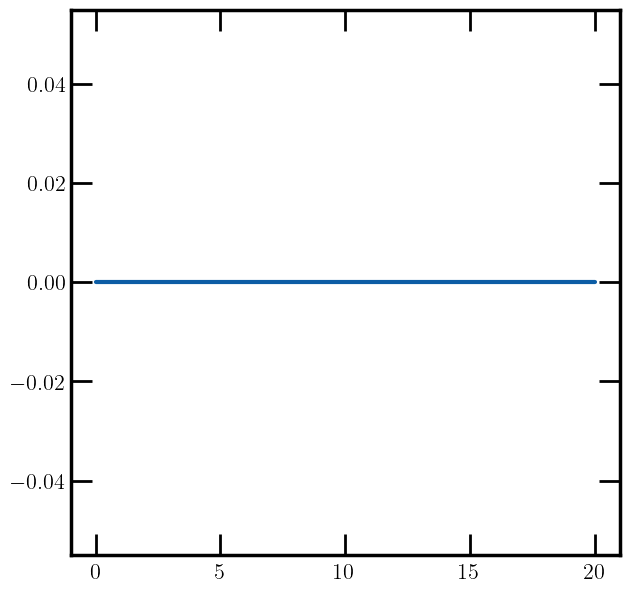

In [ ]:

# plt.yscale("log")

fig, ax = newplot("full")

plt.plot(t_from_x(xs), (data[1,:,0]))

print(data[1,:,0])

# g_star = np.array([[0. ,        0. ,        0. ,       ],
#  [-0.63661975, 0.,         0.  ,      ],
#  [0.  ,       0.    ,     0.     ,   ]])
# g_mn = np.array([[ 0.  ,      -1.3333334,],
#  [ 1.3539284, -0.8272328],
#  [ 0.        ,-0.8619376]])


# xss = jnp.logspace(-3, 0, 10000)
# ttttt = vmapped_q(t_from_x(xss), 0.118, g_star, g_mn, 0.0)

# plt.plot(t_from_x(xss), (ttttt))
# ax.plot(ts, vmapped_p_t_3(ts, 0.118, None), label=r"$\mathcal{O}(\alpha_s^3)$", color = "red")

# ax.errorbar(t_from_x(OPAL_DATA[:,0]), OPAL_DATA[:,1] * OPAL_DATA[:,0], yerr=OPAL_ERRORS * OPAL_DATA[:,0], fmt='o', label="OPAL data", c  = "black", capsize=3, lw = 1)


# Parameter Extraction

In [ ]:
N_data = 1000
alpha_true = 0.118

# Sample an exponential distribution
seed = jax.random.PRNGKey(0)
t_data = jax.random.exponential(seed, (N_data,)) / alpha_true

fig, ax = newplot("full")
bins = 100
hist_with_errors(ax, t_data, bins = bins, range = [0, 100], label = "Data", color = "black", weights=np.ones_like(t_data)/N_data)
counts, bins = np.histogram(t_data, bins = 100, range = [0, 100], density = True)
bin_centers = (bins[1:] + bins[:-1]) / 2

plt.legend()

plt.yscale("log")

In [ ]:
# Get lambda functions for FO likelihoods

def p_order_N(t, alpha, M):

    result = 0
    for i in range(M + 1):
        result += alpha  * jnp.power(-1 * alpha * t, i) / math.factorial(i)
    return result




max_M = 5


fig, ax = newplot("full")
bins = 100
hist_with_errors(ax, t_data, bins = bins, range = [0, 100], label = "Data", color = "black", weights=np.ones_like(t_data)/N_data)
counts, bins = np.histogram(t_data, bins = 100, range = [0, 100], density = True)
bin_centers = (bins[1:] + bins[:-1]) / 2

for i in range(max_M + 1):

    color = (i / max_M, 0, 1 - i / max_M)

    res = (lambda x : p_order_N(bin_centers, x, i))(0.118)
    ax.plot(bin_centers, res, label = f"Order {i}", color = color)
plt.yscale("log")



fig, ax = newplot("full")                                                                       
for i in range(max_M + 1):

    color = (i / max_M, 0, 1 - i / max_M)


    vmapped_p_order_N = jax.vmap(p_order_N, in_axes=(0, None, None))
    t_sorted = jnp.sort(t_data)
    t_sorted = t_sorted[t_sorted < 10]


    def likelihood_function(alpha):

        likelihoods = -2 * jnp.log(vmapped_p_order_N(t_sorted, alpha, i))
        cumulative_sum = jnp.cumsum(likelihoods)

        # return jnp.nanmin(cumulative_sum)
        return cumulative_sum[-1]
    


    vmapped_likelihood_function = jax.vmap(likelihood_function)
    alphas = jnp.linspace(0.00, 0.5, 1000)
    likelihoods = vmapped_likelihood_function(alphas)

    best_alpha = alphas[jnp.nanargmin(likelihoods, axis = 0)]  
    best_likelihood = likelihood_function(best_alpha)

    likelihoods = likelihoods - best_likelihood



    # best_alpha = alphas[jnp.argmin(likelihoods, axis = 0)]
    # ax.plot(t_sorted, best_alpha, label = f"Order {i}")
    
    ax.plot(alphas, likelihoods, label = f"Order {i}", color = color)



In [ ]:
from scipy.optimize import minimize


num_higher_orders = 1

max_M = 5

fig, ax = newplot("full")                                                                       
for i in range(1,max_M + 1):

    color = (i / max_M, 0, 1 - i / max_M)

    
    g_mn_matched, g_star = matching_coeffs(exponential_distribution, i, i)
    g_mn = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders))
    # print(g_mn_matched.shape)
    # print(g_mn.shape)
    # print(i+1, i)

    g_mn = g_mn.at[:i+1, :i].set(g_mn_matched)

    # We can only change parameters after the matched order in alpha
    non_frozen_params_mask = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders), dtype = bool)
    non_frozen_params_mask = non_frozen_params_mask.at[i+1:, :].set(True)


    @jax.jit
    def likelihood_function(params):

        alpha = params[0]
        g_mn_higher = params[1:]

        g_mn = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders))

        # print("")
        # print(g_mn_matched.shape)
        # print(g_mn.shape)
        # print(g_mn_higher.shape)

        g_mn = g_mn.at[:i+1, :i].set(g_mn_matched)
        g_mn = g_mn.at[i+1:, :].set(g_mn_higher)

        return -2 * jnp.sum(jnp.log(q(t_data, alpha, g_star, g_mn)))
    
    @jax.jit
    def profile_likelihood_function(g_mn_higher, alpha):

        g_mn = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders))
        g_mn = g_mn.at[:i+1, :i].set(g_mn_matched)
        g_mn = g_mn.at[i+1:, :].set(g_mn_higher)

        return -2 * jnp.sum(jnp.log(q(t_data, alpha, g_star, g_mn)))
    

    # Minimize likelihood function
    initial_alpha = 0.12
    initial_guess = jnp.zeros(g_mn.shape[1]+1)

    initial_guess = initial_guess.at[0].set(initial_alpha)


    res_full = minimize(likelihood_function, initial_guess, method='Nelder-Mead', options={'disp': False})

    alphas = jnp.linspace(0.11, 0.13, 250)

    def profile_minimize(alphas):
        res_partial = minimize(profile_likelihood_function, res_full.x[1:], args=(alphas), method='Nelder-Mead', options={'disp': False})
        return res_partial.fun

    likelihoods = jnp.zeros(alphas.shape)
    for j, alpha in enumerate(alphas):
        res_partial = profile_minimize(alpha)
        likelihoods = likelihoods.at[j].set(res_partial)

    likelihoods = likelihoods - res_full.fun

    ax.plot(alphas, likelihoods, label = f"Order {i}", color = colors[i])

    # Get the alphas where the likelihood is within 1 of the minimum
    min_alpha = alphas[jnp.argmin(likelihoods[:-1])]
    ax.axvline(min_alpha, linestyle = "--", lw = 0.5, color = colors[i])

    where_less_than_one = jnp.where(likelihoods < 1)
    alphas_less_than_one = alphas[where_less_than_one]



    minus_one = alphas_less_than_one[0]
    plus_one = alphas_less_than_one[-2]

    # Vertical band
    ax.axvspan(minus_one, plus_one, alpha=0.1, color=colors[i])

    print("Order", i)
    print("Min Alpha", min_alpha)
    print("Range", minus_one, plus_one)

    
    # vmapped_likelihood_function = jax.vmap(likelihood_function)
    # alphas = jnp.linspace(0.00, 1.0, 100)
    # likelihoods = vmapped_likelihood_function(alphas)
    

    # min_alpha = alphas[jnp.argmin(likelihoods)]

    # ax.plot(alphas, likelihoods, label = f"Order {i}", color = f"C{i}")
    # ax.axvline(min_alpha, linestyle = "--", lw = 0.5, color = f"C{i}")

ax.axvline(0.118, linestyle = "--", lw = 0.5, color = "black")

plt.yscale("log")